In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

import datetime
import FinanceDataReader as fdr
import yfinance as yf
from functools import reduce
import os

In [2]:
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")


Device set to : NVIDIA GeForce RTX 4090


In [3]:
device

device(type='cuda', index=0)

In [4]:
stocks_dict = {
    "Apple" : "AAPL", # 1.25
    "Meta" : "META", # 1.21
    "Amazon" : "AMZN", # 1.14
    "Nvidia": "NVDA", # 1.69
    "Paypal" : "PYPL", # 1.43
    "Coca" : "KO", #0.59
    "Microsoft" :"MSFT", # 0.89,
    "Tesla" : "TSLA", #2.32, Auto Manufacturers
    "General Electronic" : "GE", #1.24, Aerospace & Defense
    "Bank of America" : "BAC", #1.36, Banks - Diversified
    "Johnson & Johnson" : "JNJ", #0.53, Drug Manufacturers - General
    "Berkshir-B" : "BRK-B", # 0.88, Insurance - Diversified
    "Eli Lilly" : "LLY", #0.36, Drug Manufacturers - General
    "Broadcom" : "AVGO", #1.18, Semiconductor
    "Visa" : "V", #0.97, Credit Services
    "Exxon" : "XOM", #0.91, Oil & Gas Integrated
    "Netflix" : "NFLX", #1.26, Entertainment
    "Procter & Gamble" : "PG", #0.41, Household & Personal Products
    "Advanced" : "AMD", #1.69, Semiconductor
    "Disney" : "DIS", #1.40, entertainment
    }
stocks = list(stocks_dict.values())
num_stock = len(stocks)

tickers_index = {
    "Crude Oil": "CL=F",
    "IR": "^IRX",
    "S&P500": "^GSPC",
    "U.S. Dollar": "DX-Y.NYB"
    }

start_date = "2016-06-01"
end_date = "2024-06-10"

data_index = []
for asset, ticker in tickers_index.items():
    df1 = yf.download(ticker, start=start_date, end=end_date, interval="1d", auto_adjust = False)
    data1 = pd.DataFrame(df1)
    df = pd.DataFrame(data1)
    df.dropna(inplace=True)
    df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
    df.rename(columns={'Close': f'{ticker}-Close'}, inplace=True)
    data_index.append(df)

data_index = reduce(lambda x,y: pd.merge(x,y, on='Date', how='inner'), data_index)

data_index

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,CL=F-Close,^IRX-Close,^GSPC-Close,DX-Y.NYB-Close
Date,,,,
2016-06-01,49.009998,0.295,2099.330078,95.459999
2016-06-02,49.169998,0.270,2105.260010,95.559998
2016-06-03,48.619999,0.270,2099.129883,94.029999
2016-06-06,49.689999,0.250,2109.409912,93.900002
2016-06-07,50.360001,0.265,2112.129883,93.830002
...,...,...,...,...
2024-06-03,74.220001,5.243,5283.399902,104.139999
2024-06-04,73.250000,5.240,5291.339844,104.110001
2024-06-05,74.070000,5.240,5354.029785,104.269997


In [5]:
start = (2016, 6, 1)
start_time = datetime.datetime(*start)  
end = (2024, 6, 1)
end_time = datetime.datetime(*end) 
threshold_date = "2022-1-1"

X_train_tensors = []
X_test_tensors = []
y_train_tensors = []
y_test_tensors = []

prefix_index = None
test_index = None
MMS_list = []
for i in range(num_stock):
    df = fdr.DataReader(stocks[i], start_time, end_time)
    df = pd.concat([df, data_index], axis=1, join='inner')
    X = df.iloc[:-1, :]
    y = pd.DataFrame(df['Close']).shift(-1).dropna()

    if test_index is None:
        prefix_index = y[y.index < threshold_date].index[-95:]
        test_index = y[y.index >= threshold_date].index
    else:
        assert(test_index == y[y.index >= threshold_date].index).all()

    MMS_list.append(MinMaxScaler(feature_range = (0, 1)))

    X_data = MMS_list[i].fit_transform(X)
    y_data = MMS_list[i].fit_transform(y)

    X_df = pd.DataFrame(X_data)
    X_df.columns = X.columns
    X_df.index = X.index
    y_df = pd.DataFrame(y_data)
    y_df.columns = y.columns
    y_df.index = y.index
    
    X_train = X_df[X_df.index < threshold_date]
    X_test = X_df[X_df.index >= threshold_date]
    y_train = y_df[y_df.index < threshold_date]
    y_test = y_df[y_df.index >= threshold_date]

    X_train_tensors.append(torch.Tensor(X_train.values))
    X_test_tensors.append(torch.Tensor(X_test.values))
    y_train_tensors.append(torch.Tensor(y_train.values))
    y_test_tensors.append(torch.Tensor(y_test.values))

X_train_tensors = torch.stack(X_train_tensors)
X_test_tensors = torch.stack(X_test_tensors)
y_train_tensors = torch.stack(y_train_tensors)
y_test_tensors = torch.stack(y_test_tensors)

print(X_train_tensors.shape, X_test_tensors.shape, y_train_tensors.shape, y_test_tensors.shape)


torch.Size([20, 1406, 10]) torch.Size([20, 605, 10]) torch.Size([20, 1406, 1]) torch.Size([20, 605, 1])


In [6]:
slide_size = 5

In [27]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        batch_size, slide_size, input_size = x.shape[0], x.shape[2], x.shape[3]
        x = x.reshape(-1, slide_size, input_size)
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        out = out.reshape(batch_size, -1, 1)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(slide_size+1, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, d_slide_size, input_size = x.shape[0], x.shape[2], x.shape[3]
        x = x.reshape(-1, d_slide_size, input_size)
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)

        out = out.reshape(batch_size, -1, 1)

        return out

In [28]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for si in range(x.shape[0]):
        x_s = []
        y_s = []
        y_gan_s = []
        for i in range(window, x.shape[1]):
            tmp_x = x[si, i - window: i, :]
            tmp_y = y[si, i]
            tmp_y_gan = y[si, i - window: i + 1]
            x_s.append(tmp_x)
            y_s.append(tmp_y)
            y_gan_s.append(tmp_y_gan)
        x_s = torch.from_numpy(np.array(x_s)).float()
        y_s = torch.from_numpy(np.array(y_s)).float()
        y_gan_s = torch.from_numpy(np.array(y_gan_s)).float()

        x_.append(x_s)
        y_.append(y_s)
        y_gan.append(y_gan_s)
    x_ = torch.stack(x_)
    y_ = torch.stack(y_)
    y_gan = torch.stack(y_gan)


    return x_, y_, y_gan

In [29]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(X_train_tensors, y_train_tensors, slide_size)
test_x_slide, test_y_slide, test_y_gan = sliding_window(X_test_tensors, y_test_tensors, slide_size)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([20, 1401, 5, 10]) train_y: torch.Size([20, 1401, 1]) train_y_gan: torch.Size([20, 1401, 6, 1])
test_x: torch.Size([20, 600, 5, 10]) test_y: torch.Size([20, 600, 1]) test_y_gan: torch.Size([20, 600, 6, 1])


In [30]:
batch_size = 300
learning_rate = 0.0005
num_epochs = 1000

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(train_x_slide.shape[3]).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        fake_data = modelG(x)
        fake_data = torch.cat([y[..., :slide_size, :], fake_data.reshape(num_stock, -1, 1, 1)], axis = 2)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) / len(loss_G)
    histD[epoch] = sum(loss_D) / len(loss_D)  
    print(f'[{epoch+1}/{num_epochs}] LossD: {histD[epoch]} LossG:{histG[epoch]}')

[1/1000] LossD: 1.3876304626464844 LossG:0.7227046489715576
[2/1000] LossD: 1.3870809078216553 LossG:0.7159320116043091
[3/1000] LossD: 1.3867244720458984 LossG:0.7098023891448975
[4/1000] LossD: 1.386696457862854 LossG:0.7046411037445068
[5/1000] LossD: 1.386406421661377 LossG:0.7011268734931946
[6/1000] LossD: 1.3863742351531982 LossG:0.6981003880500793
[7/1000] LossD: 1.3863394260406494 LossG:0.6961418390274048
[8/1000] LossD: 1.3862429857254028 LossG:0.694822371006012
[9/1000] LossD: 1.3861637115478516 LossG:0.694042980670929
[10/1000] LossD: 1.3862826824188232 LossG:0.6936522722244263
[11/1000] LossD: 1.3865525722503662 LossG:0.6941589117050171
[12/1000] LossD: 1.3862566947937012 LossG:0.6931452751159668
[13/1000] LossD: 1.386286735534668 LossG:0.6931664347648621
[14/1000] LossD: 1.3862488269805908 LossG:0.6930478811264038
[15/1000] LossD: 1.3862450122833252 LossG:0.6930373311042786
[16/1000] LossD: 1.3865087032318115 LossG:0.6935445666313171
[17/1000] LossD: 1.3863874673843384 Lo

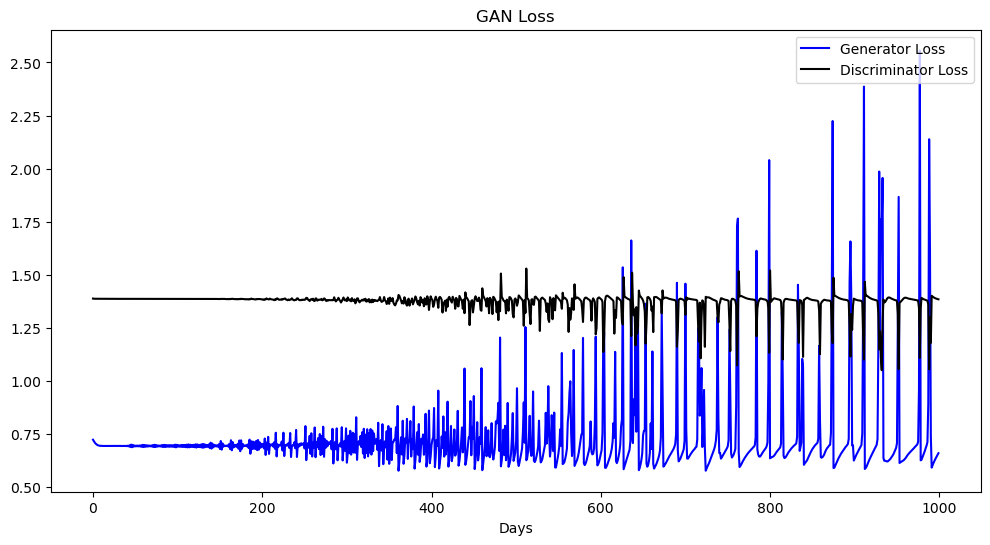

In [31]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [32]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))


y_train_true = []
y_train_pred = []
y_test_true = []
y_test_pred = []

for i in range(num_stock):
    y_train_true.append(MMS_list[i].inverse_transform(train_y_slide[i]))
    y_train_pred.append(MMS_list[i].inverse_transform(pred_y_train[i].cpu().detach().numpy()))

    y_test_true.append(MMS_list[i].inverse_transform(test_y_slide[i]))
    y_test_pred.append(MMS_list[i].inverse_transform(pred_y_test[i].cpu().detach().numpy()))

y_train_true = np.stack(y_train_true)
y_train_pred = np.stack(y_train_pred)
y_test_true = np.stack(y_test_true)
y_test_pred = np.stack(y_test_pred)

print(f"y_train_true shape: {y_train_true.shape}")
print(f"y_train_pred shape: {y_train_pred.shape}")
print(f"y_test_true shape: {y_test_true.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")

y_train_true shape: (20, 1401, 1)
y_train_pred shape: (20, 1401, 1)
y_test_true shape: (20, 600, 1)
y_test_pred shape: (20, 600, 1)


Training dataset RMSE:6.550315698753229


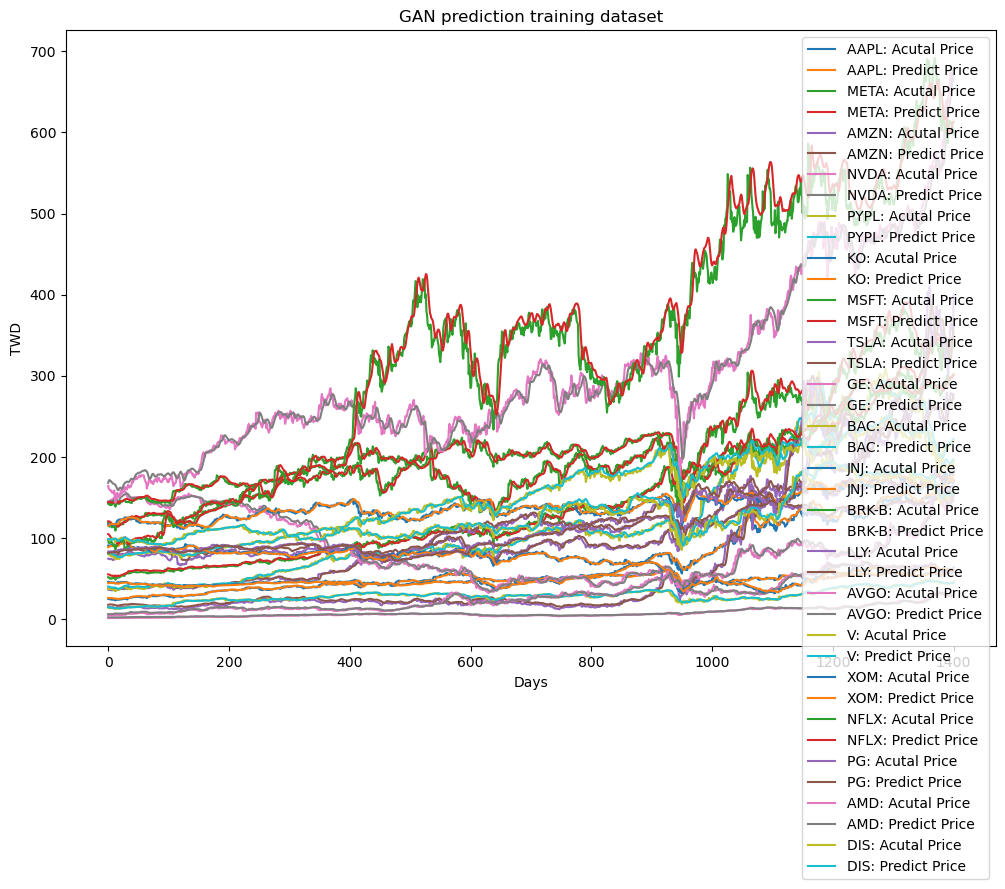

In [33]:
plt.figure(figsize=(12, 8))

for i in range(num_stock):
    plt.plot(y_train_true[i], label = f'{stocks[i]}: Acutal Price')
    plt.plot(y_train_pred[i], label = f'{stocks[i]}: Predict Price')

plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')


mse=[]
for i in range(num_stock):
    mse.append(mean_squared_error(y_train_true[i], y_train_pred[i]))

RMSE = math.sqrt(np.mean(mse))
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:13.305521265401474


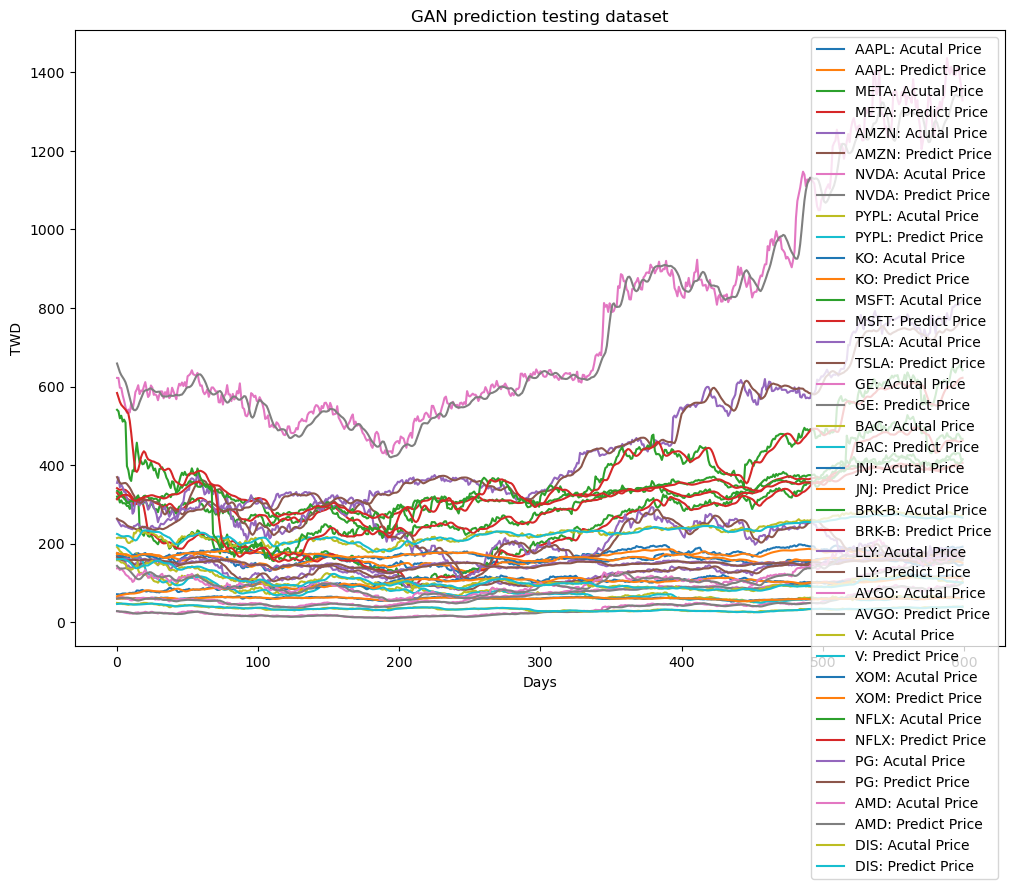

In [34]:
plt.figure(figsize=(12, 8))

for i in range(num_stock):
    plt.plot(y_test_true[i], label = f'{stocks[i]}: Acutal Price')
    plt.plot(y_test_pred[i], label = f'{stocks[i]}: Predict Price')

plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')


mse=[]
for i in range(num_stock):
    mse.append(mean_squared_error(y_test_true[i], y_test_pred[i]))

RMSE = math.sqrt(np.mean(mse))
print(f'Testing dataset RMSE:{RMSE}')

In [35]:
y_true_prefix1=[]
for i in range(num_stock):
    y_true_prefix1.append(MMS_list[i].inverse_transform(y_train_tensors[i][-95:]).squeeze())
actual_prices_prefix1 = pd.DataFrame(np.stack(y_true_prefix1).T, index=prefix_index, columns=[*stocks[:]])

y_true_prefix2=[]
for i in range(num_stock):
    y_true_prefix2.append(MMS_list[i].inverse_transform(y_test_tensors[i][:5]).squeeze())
actual_prices_prefix2 = pd.DataFrame(np.stack(y_true_prefix2).T, index=test_index[:slide_size], columns=[*stocks[:]])

y_test_true = np.squeeze(y_test_true)
actual_prefix = np.squeeze(y_train_true).T

actual_prices_data = pd.DataFrame(y_test_true.T, index = test_index[slide_size:], columns=[*stocks[:]])
actual_prices = pd.concat([actual_prices_prefix1, actual_prices_prefix2, actual_prices_data])
actual_prices


,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,JNJ,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS
Date,,,,,,,,,,,,,,,,,,,,
2021-08-18,146.700000,355.119996,159.387497,19.798000,270.579989,56.860001,296.769991,224.490000,61.940333,40.189998,178.570005,285.129999,270.400005,473.529981,231.570007,52.730001,543.710033,144.990004,103.699998,173.250004
2021-08-19,148.190006,359.369997,159.997502,20.815999,272.959993,56.639998,304.359995,226.753337,62.332836,40.369998,179.440001,285.269990,270.910009,475.169999,231.360004,52.740002,546.880000,145.089996,104.650003,175.119994
2021-08-20,149.710007,363.349998,163.293503,21.958001,276.980019,56.439999,304.650003,235.433324,62.906013,40.910000,177.610001,285.620002,267.820018,482.450025,234.140002,54.910001,553.330024,144.350004,108.769999,177.660001
2021-08-23,149.619990,365.510003,165.289003,21.792998,279.510013,56.009998,302.619990,236.163341,64.338951,41.479999,175.389997,286.019988,262.769981,481.429997,234.240010,55.360002,553.409969,143.179990,107.650004,178.470004
2021-08-24,148.360000,368.390009,164.959002,22.212999,277.689994,56.069999,302.010002,237.066669,65.229865,42.150001,174.229995,287.299980,263.870002,483.410000,232.589998,55.459998,547.580032,142.670001,108.300008,178.309997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,189.979995,478.220007,180.749996,106.468999,61.640000,61.999999,430.159995,179.240001,167.330002,39.700001,146.970001,407.410002,807.429976,1407.839999,274.489986,113.419998,646.750005,165.330004,166.360004,101.760002
2024-05-24,189.990003,479.920002,182.149990,113.901002,62.169998,61.820000,430.320008,176.749996,168.559999,39.319999,144.380004,403.900002,807.859966,1412.449925,270.980011,114.860003,649.000017,163.109999,171.609999,102.440002
2024-05-28,190.289998,474.359981,182.020003,114.824997,61.049998,61.700001,429.170017,176.190004,163.600007,38.720002,144.440001,404.090002,811.530014,1390.670015,268.859982,113.629996,654.620006,161.649994,165.139994,100.879997


In [36]:
y_test_pred = np.squeeze(y_test_pred)
generated_prices = pd.DataFrame(y_test_pred.T, index = test_index[slide_size:], columns=[*stocks[:]])
generated_prices

,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,JNJ,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS
Date,,,,,,,,,,,,,,,,,,,,
2022-01-10,176.319107,341.369720,166.882950,28.367937,196.025589,60.171093,329.276459,369.497803,60.699406,46.473728,173.196808,312.891296,263.973236,658.739258,224.748749,66.091026,583.603943,160.344116,143.435562,160.341187
2022-01-11,174.711670,338.771515,165.477356,27.671303,194.162354,60.431610,324.405334,361.603424,61.334599,46.912041,173.586594,316.887299,260.974548,647.863770,223.277908,67.498978,571.916931,160.375275,139.609589,160.484650
2022-01-12,173.286011,337.062561,164.358994,27.179502,192.794403,60.477375,320.875702,354.884247,61.576912,47.127354,173.778061,319.832703,259.319427,636.695679,220.919647,68.452789,561.142151,159.915558,136.833389,160.530334
2022-01-13,172.938309,337.855652,164.186279,27.058802,192.340607,60.449005,320.319641,352.712036,61.807892,47.342461,173.497040,321.844452,257.587769,629.196838,219.297623,69.332069,553.636353,159.116562,136.377625,160.828644
2022-01-14,173.274307,338.207153,164.349258,26.983177,191.455246,60.462421,320.251404,353.574310,62.114594,47.491066,173.046692,323.530701,256.308899,623.528625,218.592209,70.045029,549.474304,158.315170,136.678253,160.961517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,182.516312,460.723480,176.409241,93.212898,61.081345,62.316353,402.607971,174.000214,154.531982,39.353836,155.309479,397.727173,754.120544,1341.285156,269.521149,114.080986,611.427063,162.057556,161.382156,102.007431
2024-05-24,182.513977,459.643524,176.097702,94.106415,60.775497,62.192711,403.762268,175.102036,154.576385,39.424286,154.826111,397.358215,758.769653,1338.579712,268.773987,113.675072,616.116516,162.021591,161.684906,101.743401
2024-05-28,182.455811,459.713409,175.729172,96.001068,60.288368,62.060249,405.037872,175.516586,155.295197,39.468903,153.754578,396.351288,764.427368,1338.769043,268.015228,112.960472,619.644958,161.848587,161.401688,101.385185


In [37]:
data_index_after = data_index.drop(['CL=F-Close', '^GSPC-Close', 'DX-Y.NYB-Close'], axis=1)

actual_prices_w_rf = actual_prices.join(data_index_after)
generated_prices_w_rf = generated_prices.join(data_index_after)


In [38]:
actual_prices_w_rf

,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,...,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS,^IRX-Close
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-18,146.700000,355.119996,159.387497,19.798000,270.579989,56.860001,296.769991,224.490000,61.940333,40.189998,...,285.129999,270.400005,473.529981,231.570007,52.730001,543.710033,144.990004,103.699998,173.250004,0.055
2021-08-19,148.190006,359.369997,159.997502,20.815999,272.959993,56.639998,304.359995,226.753337,62.332836,40.369998,...,285.269990,270.910009,475.169999,231.360004,52.740002,546.880000,145.089996,104.650003,175.119994,0.043
2021-08-20,149.710007,363.349998,163.293503,21.958001,276.980019,56.439999,304.650003,235.433324,62.906013,40.910000,...,285.620002,267.820018,482.450025,234.140002,54.910001,553.330024,144.350004,108.769999,177.660001,0.043
2021-08-23,149.619990,365.510003,165.289003,21.792998,279.510013,56.009998,302.619990,236.163341,64.338951,41.479999,...,286.019988,262.769981,481.429997,234.240010,55.360002,553.409969,143.179990,107.650004,178.470004,0.040
2021-08-24,148.360000,368.390009,164.959002,22.212999,277.689994,56.069999,302.010002,237.066669,65.229865,42.150001,...,287.299980,263.870002,483.410000,232.589998,55.459998,547.580032,142.670001,108.300008,178.309997,0.048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,189.979995,478.220007,180.749996,106.468999,61.640000,61.999999,430.159995,179.240001,167.330002,39.700001,...,407.410002,807.429976,1407.839999,274.489986,113.419998,646.750005,165.330004,166.360004,101.760002,5.245
2024-05-24,189.990003,479.920002,182.149990,113.901002,62.169998,61.820000,430.320008,176.749996,168.559999,39.319999,...,403.900002,807.859966,1412.449925,270.980011,114.860003,649.000017,163.109999,171.609999,102.440002,5.245
2024-05-28,190.289998,474.359981,182.020003,114.824997,61.049998,61.700001,429.170017,176.190004,163.600007,38.720002,...,404.090002,811.530014,1390.670015,268.859982,113.629996,654.620006,161.649994,165.139994,100.879997,5.248


In [39]:
generated_prices_w_rf

,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,...,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS,^IRX-Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-10,176.319107,341.369720,166.882950,28.367937,196.025589,60.171093,329.276459,369.497803,60.699406,46.473728,...,312.891296,263.973236,658.739258,224.748749,66.091026,583.603943,160.344116,143.435562,160.341187,0.090
2022-01-11,174.711670,338.771515,165.477356,27.671303,194.162354,60.431610,324.405334,361.603424,61.334599,46.912041,...,316.887299,260.974548,647.863770,223.277908,67.498978,571.916931,160.375275,139.609589,160.484650,0.118
2022-01-12,173.286011,337.062561,164.358994,27.179502,192.794403,60.477375,320.875702,354.884247,61.576912,47.127354,...,319.832703,259.319427,636.695679,220.919647,68.452789,561.142151,159.915558,136.833389,160.530334,0.115
2022-01-13,172.938309,337.855652,164.186279,27.058802,192.340607,60.449005,320.319641,352.712036,61.807892,47.342461,...,321.844452,257.587769,629.196838,219.297623,69.332069,553.636353,159.116562,136.377625,160.828644,0.110
2022-01-14,173.274307,338.207153,164.349258,26.983177,191.455246,60.462421,320.251404,353.574310,62.114594,47.491066,...,323.530701,256.308899,623.528625,218.592209,70.045029,549.474304,158.315170,136.678253,160.961517,0.118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,182.516312,460.723480,176.409241,93.212898,61.081345,62.316353,402.607971,174.000214,154.531982,39.353836,...,397.727173,754.120544,1341.285156,269.521149,114.080986,611.427063,162.057556,161.382156,102.007431,5.245
2024-05-24,182.513977,459.643524,176.097702,94.106415,60.775497,62.192711,403.762268,175.102036,154.576385,39.424286,...,397.358215,758.769653,1338.579712,268.773987,113.675072,616.116516,162.021591,161.684906,101.743401,5.245
2024-05-28,182.455811,459.713409,175.729172,96.001068,60.288368,62.060249,405.037872,175.516586,155.295197,39.468903,...,396.351288,764.427368,1338.769043,268.015228,112.960472,619.644958,161.848587,161.401688,101.385185,5.248


In [50]:
data_index_after = data_index.drop(['CL=F-Close', '^GSPC-Close', 'DX-Y.NYB-Close'], axis=1)
SP_500_after = data_index.drop(['CL=F-Close', '^IRX-Close', 'DX-Y.NYB-Close'], axis=1)
actual_prices_w_SP = actual_prices.join(SP_500_after)
actual_prices_w_rf = actual_prices.join(data_index_after)
generated_prices_w_rf = generated_prices.join(data_index_after)
generated_prices_w_SP = generated_prices.join(SP_500_after)

actual_prices_w_SP

,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,...,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS,^GSPC-Close
Date,,,,,,,,,,,,,,,,,,,,,
2021-08-18,146.700000,355.119996,159.387497,19.798000,270.579989,56.860001,296.769991,224.490000,61.940333,40.189998,...,285.129999,270.400005,473.529981,231.570007,52.730001,543.710033,144.990004,103.699998,173.250004,4400.270020
2021-08-19,148.190006,359.369997,159.997502,20.815999,272.959993,56.639998,304.359995,226.753337,62.332836,40.369998,...,285.269990,270.910009,475.169999,231.360004,52.740002,546.880000,145.089996,104.650003,175.119994,4405.799805
2021-08-20,149.710007,363.349998,163.293503,21.958001,276.980019,56.439999,304.650003,235.433324,62.906013,40.910000,...,285.620002,267.820018,482.450025,234.140002,54.910001,553.330024,144.350004,108.769999,177.660001,4441.669922
2021-08-23,149.619990,365.510003,165.289003,21.792998,279.510013,56.009998,302.619990,236.163341,64.338951,41.479999,...,286.019988,262.769981,481.429997,234.240010,55.360002,553.409969,143.179990,107.650004,178.470004,4479.529785
2021-08-24,148.360000,368.390009,164.959002,22.212999,277.689994,56.069999,302.010002,237.066669,65.229865,42.150001,...,287.299980,263.870002,483.410000,232.589998,55.459998,547.580032,142.670001,108.300008,178.309997,4486.229980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,189.979995,478.220007,180.749996,106.468999,61.640000,61.999999,430.159995,179.240001,167.330002,39.700001,...,407.410002,807.429976,1407.839999,274.489986,113.419998,646.750005,165.330004,166.360004,101.760002,5267.839844
2024-05-24,189.990003,479.920002,182.149990,113.901002,62.169998,61.820000,430.320008,176.749996,168.559999,39.319999,...,403.900002,807.859966,1412.449925,270.980011,114.860003,649.000017,163.109999,171.609999,102.440002,5304.720215
2024-05-28,190.289998,474.359981,182.020003,114.824997,61.049998,61.700001,429.170017,176.190004,163.600007,38.720002,...,404.090002,811.530014,1390.670015,268.859982,113.629996,654.620006,161.649994,165.139994,100.879997,5306.040039


In [49]:
a = generated_prices_w_rf.index.tolist()
print(a[0], a[99])
print(a[100], a[199])
print(a[200], a[299])
print(a[300], a[399])
print(a[400], a[499])
print(a[500], a[599])

2022-01-10 00:00:00 2022-06-02 00:00:00
2022-06-03 00:00:00 2022-10-25 00:00:00
2022-10-26 00:00:00 2023-03-21 00:00:00
2023-03-22 00:00:00 2023-08-14 00:00:00
2023-08-15 00:00:00 2024-01-05 00:00:00
2024-01-08 00:00:00 2024-05-30 00:00:00


In [40]:
generated_prices_w_rf.pct_change().dropna()


,AAPL,META,AMZN,NVDA,PYPL,KO,MSFT,TSLA,GE,BAC,...,BRK-B,LLY,AVGO,V,XOM,NFLX,PG,AMD,DIS,^IRX-Close
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-11,-0.009117,-0.007611,-0.008423,-0.024557,-0.009505,0.004330,-0.014793,-0.021365,0.010465,0.009431,...,0.012771,-0.011360,-0.016510,-0.006544,0.021303,-0.020026,0.000194,-0.026674,0.000895,0.311111
2022-01-12,-0.008160,-0.005045,-0.006758,-0.017773,-0.007045,0.000757,-0.010880,-0.018582,0.003951,0.004590,...,0.009295,-0.006342,-0.017238,-0.010562,0.014131,-0.018840,-0.002867,-0.019885,0.000285,-0.025424
2022-01-13,-0.002007,0.002353,-0.001051,-0.004441,-0.002354,-0.000469,-0.001733,-0.006121,0.003751,0.004564,...,0.006290,-0.006678,-0.011778,-0.007342,0.012845,-0.013376,-0.004996,-0.003331,0.001858,-0.043478
2022-01-14,0.001943,0.001040,0.000993,-0.002795,-0.004603,0.000222,-0.000213,0.002445,0.004962,0.003139,...,0.005239,-0.004965,-0.009009,-0.003217,0.010283,-0.007518,-0.005037,0.002204,0.000826,0.072727
2022-01-18,0.001199,-0.001898,-0.000335,-0.004255,-0.008971,0.001619,-0.002721,0.001948,0.003479,-0.001492,...,0.002242,-0.010047,-0.009068,-0.000911,0.008700,-0.007022,-0.004152,0.003386,-0.006046,0.101695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-23,0.002139,-0.003902,-0.001612,0.001870,-0.003885,-0.000916,0.002769,0.006527,-0.001829,0.002506,...,0.000952,0.004219,-0.001553,-0.000997,-0.000744,0.007902,0.001547,0.009349,-0.001371,0.000000
2024-05-24,-0.000013,-0.002344,-0.001766,0.009586,-0.005007,-0.001984,0.002867,0.006332,0.000287,0.001790,...,-0.000928,0.006165,-0.002017,-0.002772,-0.003558,0.007670,-0.000222,0.001876,-0.002588,0.000000
2024-05-28,-0.000319,0.000152,-0.002093,0.020133,-0.008015,-0.002130,0.003159,0.002367,0.004650,0.001132,...,-0.002534,0.007456,0.000141,-0.002823,-0.006286,0.005727,-0.001068,-0.001752,-0.003521,0.000572


In [41]:
def make_mu(data):
    data = np.log(data/data.shift(1)).dropna()
    mu = (data.mean() * len(data)).to_numpy()
    return mu

def make_cov(data):
    return (data.cov()*len(data)).to_numpy()

def portfolio_return(weights, return_matrix):
    return np.dot(weights, return_matrix)


In [65]:
return_w_past_data = []
tangent_portfolio_w_past_data = []

betas_last=None

a = actual_prices.shape[0]//100
for i in range(a-1):
    betas = []
    
    price_data = actual_prices_w_rf.iloc[100*i:100*(i+1), :20]
    price_data_next = actual_prices_w_rf.iloc[100*(i+1):100*(i+2), :20]
    rf_data = actual_prices_w_rf.iloc[100*i:100*(i+1), 20].tolist()
    rf_data_next = actual_prices_w_rf.iloc[100*(i+1):100*(i+2), 20].tolist()
    price_w_rf_next = actual_prices_w_rf.iloc[100*(i+1):100*(i+2), :21]
    SP_data = actual_prices_w_SP.iloc[100*(i+1):100*(i+2), 20]
    SP_change = SP_data.pct_change().dropna()
    
    rf_past = sum(rf_data)/len(rf_data)
    rf_now = sum(rf_data_next)/len(rf_data_next)
    mu_past = make_mu(price_data)
    cov_past = make_cov(price_data)
    cov_now = make_cov(price_data_next)
    SP_now = sum(SP_change)/len(SP_change)

    # tagent portfolio
    v = np.dot(np.linalg.inv(cov_past), (mu_past - rf_past))
    w = v/sum(v)
    tangent_portfolio_w_past_data.append(w)

    # Get variance
    variance = np.sqrt(np.dot(w.T, np.dot(cov_now, w)))
    
    # real return of portfolio
    mu_next = make_mu(price_data_next)
    port_return = portfolio_return(w, mu_next)
    
    #Make betas
    for j in range(20):
        beta = (mu_next[j] - rf_now) / (SP_now - rf_now)
        betas.append(beta)
    port_beta = np.dot(w, betas)
    
    return_w_past_data.append([port_return.item(), variance, port_beta])

return_period = pd.DataFrame(return_w_past_data, columns=['return: Basic CAPM', 'variance : Basic CAPM', 'portfolio beta : Basic CAPM'])
print(return_period)
print(reduce(lambda x, y: x*y, [(1+x) for x in return_period['return: Basic CAPM'].squeeze().tolist()]))


   return: Basic CAPM  variance : Basic CAPM  portfolio beta : Basic CAPM
0           -0.344079              28.432541                     1.635404
1           -0.243181              10.872954                     1.094717
2            0.373491              15.159772                     0.914965
3            0.185337              11.931112                     0.963651
4            0.068898              13.310490                     0.987058
5            0.243167              38.675945                     0.953667
1.0739325866121545


In [66]:
return_w_generated_data = []
tangent_portfolio_w_generated_data = []
betas_last = None

a = generated_prices.shape[0]//100
for i in range(a):
    betas = []
    
    price_data = generated_prices_w_rf.iloc[100*i:100*(i+1), :20]
    price_data_real = actual_prices_w_rf.iloc[100*(i+1):100*(i+2), :20]
    SP_data = actual_prices_w_SP.iloc[100*(i+1):100*(i+2), 20]
    SP_change = SP_data.pct_change().dropna()
    # past risk free rate
    rf_data = actual_prices_w_rf.iloc[100*i:100*(i+1), 20].tolist()
    rf_data_next = actual_prices_w_rf.iloc[100*(i+1):100*(i+2), 20].tolist()
    SP_now = sum(SP_change)/len(SP_change)

    rf_past = sum(rf_data)/len(rf_data)
    rf_next = sum(rf_data_next)/len(rf_data_next)
    mu_generated = make_mu(price_data)
    cov_generated = make_cov(price_data)
    cov_real = make_cov(price_data_real)

    # tagent portfolio
    v = np.dot(np.linalg.inv(cov_generated), (mu_generated - rf_past))
    w = v/sum(v)
    tangent_portfolio_w_generated_data.append(w)
    
    # Get variance
    variance = np.sqrt(np.dot(w.T, np.dot(cov_real, w)))

    # real return of portfolio
    mu_gen = make_mu(price_data)
    mu_real = make_mu(price_data_real)
    port_return = portfolio_return(w, mu_real)
    
    #Make betas
    for j in range(20):
        beta = (mu_real[j] - rf_next) / (SP_now - rf_next)
        betas.append(beta)
    port_beta = np.dot(w.T, betas)
    
    return_w_generated_data.append([port_return.item(), variance, port_beta])

return_period = pd.DataFrame(return_w_generated_data, columns=['return: GAN based CAPM', 'variance : GAN based CAPM', 'portfolio beta : GAN based CAPM'])
print(return_period)
print(reduce(lambda x, y: x*y, [(1+x) for x in return_period['return: GAN based CAPM'].squeeze().tolist()]))


   return: GAN based CAPM  variance : GAN based CAPM  \
0               -0.298849                   5.801892   
1               -0.199909                   4.878256   
2                0.244258                   5.345654   
3               -0.060107                  11.022012   
4                0.102872                   5.500140   
5                0.021057                   6.056501   

   portfolio beta : GAN based CAPM  
0                         1.551633  
1                         1.077827  
2                         0.944430  
3                         1.012142  
4                         0.980620  
5                         0.996159  
0.7387799372781005
